In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from bandits import *
from strategies import *

In [2]:
# plot parameters
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

In [3]:
synchcommname = 'SIC-MMAB'

# Simulate

In [13]:
# simulation parameters
horizon = 500000
K = 9
means = np.linspace(0.9, 0.89, K)
nplayers = 6
n_simu = 2

# list of strategies to compare
strategies = [(MCTopM, 'MCTopM', {'M':nplayers}), (SynchComm, 'SynchComm', {})]

# try to load for a warm restart
try:
    scores_1 = np.load('scores/scores_1.npy').item()
except FileNotFoundError:
    scores_1 = {}
    
try:  
    raw_scores_1 = np.load('scores/raw_scores_1.npy').item()
except:
    raw_scores_1 = {}
    
# if we decide to interrupt the running code, it saves the current state of all the stored scores
try:
    for strat, strat_name, args in strategies:
        if strat_name not in scores_1.keys():
            try:
                # the number of runs to run for this algo
                nalgo = n_simu-len(raw_scores_1[strat_name])
            except KeyError:
                # case of algo not loaded (ie 0 run already done)
                raw_scores_1[strat_name] = []
                nalgo = n_simu
            for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format(strat_name)):
                MAB = FullSensingMultiPlayerMAB(means, nplayers=nplayers, strategy=strat, T=horizon, **args) # simulate a run with the chosen parameters
                r, _ = MAB.simulate(horizon)
                raw_scores_1[strat_name].append(r)            
            scores_1[strat_name] = np.mean(raw_scores_1[strat_name], axis=0) # average on all runs
        
            del raw_scores_1[strat_name]
            del r
    
    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores/raw_scores_1.npy', raw_scores_1)
    np.save('scores/scores_1.npy', scores_1)
    
except KeyboardInterrupt:
    # save in case of interruption
    print('Number of tries ran for %s : %d' %(strat_name, len(raw_scores_1[strat_name])))
    np.save('scores/raw_scores_1.npy', raw_scores_1)
    np.save('scores/scores_1.npy', scores_1)
    del raw_scores_1

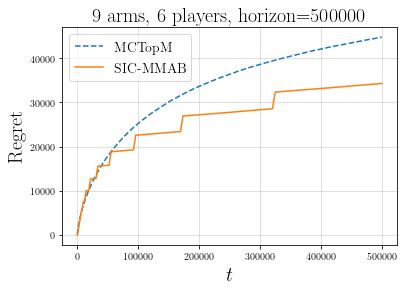

In [18]:
# plot evolution of regret
fig = plt.figure()
horizon_plot = -1
ls = ['--', '-']
for i,z in enumerate(strategies):
    strat, strat_name, _ = z
    if strat_name=='SynchComm':
        name=synchcommname
    else:
        name = strat_name
    plt.plot(scores_1[strat_name][:horizon_plot], ls[i], label=name)
plt.title('{} arms, {} players, horizon={}'.format(K, nplayers, horizon), fontsize=20)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)
fig.savefig('figures/K{}_M{}_delta{}.pgf'.format(K, nplayers, (int)(1000*(means[0]-means[1]))))
plt.show()

# Simulating for several Deltas

In [6]:
try:
    del scores_1 # free memory space
except:
    pass

# simulation parameters
horizon = 500000
K = 9
deltas = np.linspace(0.001, 0.0001, 10)
nplayers = 6
n_simu = 2

strategies = [(MCTopM, 'MCTopM', {'M':nplayers}), (SynchComm, 'SynchComm', {})] # strategies to compare

# try to load for a warm restart
try:
    scores_delta = np.load('scores/scores_delta.npy').item()
except FileNotFoundError:
    scores_delta = {}
    
try:  
    raw_scores_delta = np.load('scores/raw_scores_delta.npy').item()
except:
    raw_scores_delta = {}
    
# if we decide to interrupt the running code, it saves the current state of all the stored scores
try:
    for delta in deltas:
        means = np.linspace(0.9, 0.9-delta*K, K) # generate means for a given delta
        for strat, strat_name, args in strategies:
            if (delta, strat_name) not in scores_delta.keys():
                try:
                    # the number of runs to do for this algo
                    nalgo = n_simu-len(raw_scores_delta[(delta, strat_name)])
                except KeyError:
                    # case of algo not loaded (ie 0 run already done)
                    raw_scores_delta[(delta, strat_name)] = []
                    nalgo = n_simu
                for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format(strat_name)):
                    MAB = FullSensingMultiPlayerMAB(means, nplayers=nplayers, strategy=strat, T=horizon, **args) # 1 run with given parmaters
                    r, _ = MAB.simulate(horizon)
                    raw_scores_delta[(delta, strat_name)].append(r)            
                scores_delta[(delta, strat_name)] = np.mean(raw_scores_delta[(delta, strat_name)], axis=0) # average on all runs

                del raw_scores_delta[(delta, strat_name)]
                del r
    
    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores/raw_scores_delta.npy', raw_scores_delta)
    np.save('scores/scores_delta.npy', scores_delta)
    
except KeyboardInterrupt:
    # save in case of interruption
    print('Number of tries ran for delta=%f and %s : %d' %(delta, strat_name, len(raw_scores_delta[(delta, strat_name)])))
    np.save('scores/raw_scores_delta.npy', raw_scores_delta)
    np.save('scores/scores_delta.npy', scores_delta)
    del raw_scores_delta

In [7]:
# only keep the final regret
deltas = np.unique(np.array(list(scores_delta.keys()))[:, 0]).astype(float)
scores_delta_end = {}
for strat, strat_name, _ in strategies:
    scores_delta_end[strat_name] = np.zeros(len(deltas))
    for i, delta in enumerate(deltas):
        scores_delta_end[strat_name][i] = scores_delta[(delta, strat_name)][horizon-1]

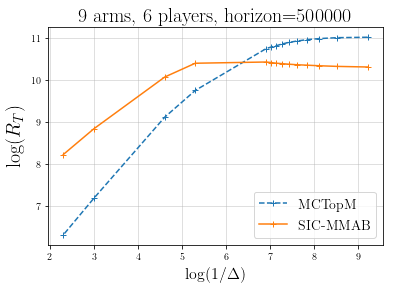

In [20]:
# plot the evolution of R_T as a function of Delta
fig = plt.figure()
ls = ['--+', '-+']
for i,z  in enumerate(strategies):
    strat, strat_name, _ = z
    if strat_name=='SynchComm':
        name=synchcommname
    else:
        name = strat_name
    plt.plot(np.log(np.array(1/deltas)), np.log(scores_delta_end[strat_name]), ls[i], label=name)
plt.legend(fontsize=14, loc='lower right')
plt.xlabel('$\log(1/\Delta)$', fontsize=16)
plt.ylabel('$\log(R_T)$', fontsize=20)
plt.grid(alpha=0.5)
plt.title('{} arms, {} players, horizon={}'.format(K, nplayers, horizon), fontsize=20)
fig.savefig('figures/logvaryingdelta_K{}_M{}_T{}.pgf'.format(K, nplayers, horizon))
plt.show()

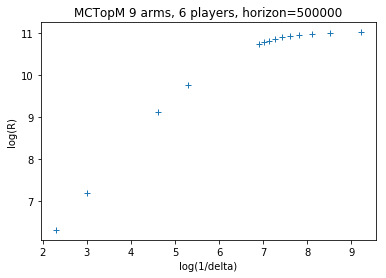

In [44]:
strat_name='MCTopM'
fig = plt.figure()
plt.plot(np.log(np.array(1/deltas)), np.log(scores_delta_end[strat_name]), '+')
plt.xlabel('log(1/delta)')
plt.ylabel('log(R)')
plt.title('{} {} arms, {} players, horizon={}'.format(strat_name, K, nplayers, horizon))
fig.savefig('figures/{}_varyingdelta_K{}_M{}_T{}'.format(strat_name, K, nplayers, horizon))
plt.show()

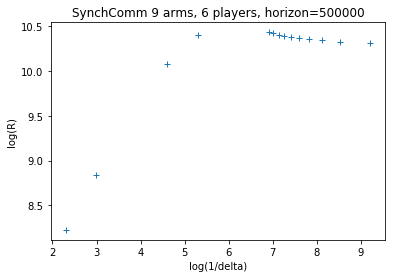

In [45]:
strat_name='SynchComm'
fig = plt.figure()
plt.plot(np.log(1/np.array(deltas)), np.log(scores_delta_end[strat_name]), '+')
plt.xlabel('log(1/delta)')
plt.ylabel('log(R)')
plt.title('{} {} arms, {} players, horizon={}'.format(strat_name, K, nplayers, horizon))
fig.savefig('figures/{}_varyingdelta_K{}_M{}_T{}'.format(strat_name, K, nplayers, horizon))
plt.show()